In [1]:
# Clear memory
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import ipywidgets
ipywidgets.Widget.close_all()

import SimpleITK
import datetime
import gc # Garbage collected
import numpy as np
import sys, os
import time
import tifffile
import matplotlib.pyplot as plt
import scipy
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askopenfilenames, askdirectory
import torch
import skimage
from skimage import measure

this_path = os.getcwd()
print(this_path)


import h5py
# import File
from scripts import *
import wrapper_ASTRA


/global/u2/e/eboigne/tomoTools_als832/tomoTools


In [ ]:
path_save = '/global/homes/e/eboigne/cfs_als/2022_wood/'

# case = 'run21_oak_lowHeat'
# case = 'run23_walnut_lowHeat'
case = 'run24_birch_lowHeat'
# case = 'run26_birch_highHeat'

list_cases = sorted([e for e in os.listdir(path_save+case) if not 'probe' in e and not '.tif' in e])
print(list_cases)

In [4]:
ind_slice = 250

slices = []
for ind_case, this_case in enumerate(list_cases[:]):
    slices.append(File(path_save+case+'/'+this_case+'/b_movingRegisteredToStatic/').read(ind_slice))
    print(ind_case, this_case)

slices = np.array(slices)
print(slices.shape)
File(path_save+case+'/probe_slice_'+str(ind_slice).zfill(4)).saveTiffStack(slices)

0 01
1 02
2 03
3 04
4 05
5 06
6 07
7 08a
8 08b
9 09a
10 09b
11 10a
12 10b
13 11a
14 11b
15 12a
16 12b
17 13a
18 13b
19 14a
20 14b
21 15a
22 15b
23 16a
24 16b
25 17a
26 17b
27 18a
28 18b
29 19a
30 19b
31 20a
32 20b
33 21a
34 21b
35 22
36 23
37 24
(38, 1280, 1280)


In [5]:
scan_to_test = '01'

In [10]:
tic = time.time()
data = File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic/').readAll()
print('Loading data took: '+str(time.time()-tic))
print(data.shape)


Loading data took: 7.288534164428711
(698, 1280, 1280)


In [11]:
threshold = 0.05 # Linear attenuation threshold [/cm]
threshold_needle = 4.0 # Linear attenuation threshold [/cm]
mask_growth_needle = 10 # Grow the mask obtained using threshold_needle with this amount of pixels
mask_enclosing_circle = tifffile.imread(path_save+case+'/maskEnclosingCircle.tif') > 0

bin_factor_dilatation = 1 # Binning before smoothing, as an option to speed things up for large kernels
filter_half_width = 3 #  After binning (equal to sigma for gaussian filter)

# kernel = custom_3d_kernel_sphere(filter_half_width)
kernel = custom_3d_gaussian_filter(filter_half_width)
# filter_half_width = (kernel.shape[0]-1)/2

tic = time.time()
if bin_factor_dilatation > 1:
    data_smoothed = fast_pytorch_bin_3d(data,bin_factor_dilatation, chunk_size = 71)
else:
    data_smoothed = data

print(data_smoothed.shape)
data_smoothed = apply_3d_image_processing_on_subvolumes(data_smoothed, fast_pytorch_convolution, kernel_array = kernel, chunk_size_max = (500, 500, 500), overlap = 3*filter_half_width)
print(data_smoothed.shape)

if bin_factor_dilatation > 1:
    data_smoothed = skimage.transform.rescale(data_smoothed, bin_factor_dilatation, multichannel=False)
print('Smoothing data took: '+str(time.time()-tic))

# Save smoothed data
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_smoothed_bin'+str(bin_factor_dilatation)+'x_FHW_'+str(filter_half_width)).saveTiffStack(data_smoothed)

mask_needle = data_smoothed > threshold_needle
mask_needle = apply_3d_image_processing_on_subvolumes(mask_needle, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = mask_growth_needle, radius = mask_growth_needle)
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskNeedle').saveTiffStack(mask_needle, type = 'bool')

mask_solid = data_smoothed > threshold
mask_solid[mask_needle] = False
for ind, slice in enumerate(mask_solid):
    slice[~mask_enclosing_circle] = False
    mask_solid[ind] = slice
    if ind % 100 == 0:
        print(ind)

File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolid').saveTiffStack(mask_solid, type = 'bool')

(698, 1280, 1280)
	 Processing 18 chunks of size [349 426 426] .................. Done
(698, 1280, 1280)
Smoothing data took: 28.15023112297058
	 Processing 18 chunks of size [349 426 426] .................. Done
0
100
200
300
400
500
600


In [12]:
ind_bottom = 100
ind_top = 610

mask_solid[:ind_bottom] = False
mask_solid[ind_top:] = False

	 Processing 18 chunks of size [349 426 426] .................. Done
	 Processing 18 chunks of size [349 426 426] .................. Done


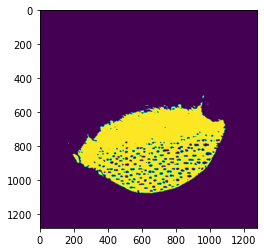

In [13]:
slice = mask_solid[ind_top-1]
plt.imshow(slice)

filter_half_width = 12

mask_solid_dilated = apply_3d_image_processing_on_subvolumes(mask_solid, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = filter_half_width, radius = filter_half_width)
# print('1')
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolidDilated').saveTiffStack(mask_solid_dilated, type = 'bool')
mask_solid_closed = ~apply_3d_image_processing_on_subvolumes(~mask_solid_dilated, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = filter_half_width, radius = filter_half_width)
# print('Closing data took: '+str(time.time()-tic))
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolidClosed').saveTiffStack(mask_solid_closed, type = 'bool')

In [14]:
# filter_half_width = 1
# mask_solid_closed_dilated = apply_3d_image_processing_on_subvolumes(mask_solid_closed, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = filter_half_width, radius = filter_half_width)
# mask_pores_with_borders = mask_solid_closed_dilated * (~mask_solid)
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPoresWithBorders').saveTiffStack(mask_pores_with_borders, type = 'bool')

mask_pores = mask_solid_closed * (~mask_solid)
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPores').saveTiffStack(mask_pores, type = 'bool')

tic = time.time()
lab = measure.label(mask_pores)
print('Particle identification took: '+str(time.time()-tic))

Particle identification took: 7.798318147659302


In [15]:
File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPores_particleLabels').saveTiffStack(lab)


In [6]:
lab = File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPores_particleLabels').readAll().astype('int')
print('Done loading data')

Done loading data


In [7]:
tic = time.time()
properties = measure.regionprops(lab)
print('Particle analysis took: '+str(time.time()-tic))


Particle analysis took: 3.199970245361328


In [8]:
areas = np.array([prop.area for prop in properties])
ind_properties_cleaned = np.where((areas>500) * (areas < 300000))[0]
print(len(ind_properties_cleaned))

properties_cleaned = [prop for prop in properties if prop.area > 500]

794


In [9]:
# lab_cleaned = np.zeros_like(lab)
# for prop in properties:
#     lab_cleaned[lab==prop.label] = prop.label
#     print(prop.label)
# properties_cleaned = measure.regionprops(lab_cleaned)

In [10]:
areas = [prop.area for prop in properties_cleaned]

voxel_size = 3.24*2 # [microns]

for ind_pore in range(len(ind_properties_cleaned)):

    # Equivalent cylinder diameter & height
    bbox = properties[ind_properties_cleaned[ind_pore]].bbox
    properties[ind_properties_cleaned[ind_pore]].height = bbox[3]-bbox[0] # Along z, in pixels
    equivalent_cylinder_cross_section = properties[ind_properties_cleaned[ind_pore]].area / properties[ind_properties_cleaned[ind_pore]].height
    properties[ind_properties_cleaned[ind_pore]].equivalent_cylinder_diameter = np.sqrt(4*equivalent_cylinder_cross_section/np.pi) * voxel_size
    # print(ind_pore, ind_properties_cleaned[ind_pore], properties[ind_properties_cleaned[ind_pore]].equivalent_cylinder_diameter)

    # Perimeter

equivalent_cylinder_diameters = [prop.equivalent_cylinder_diameter for prop in np.array(properties)[ind_properties_cleaned]]


Done


Text(0.5, 0, '$D_{eq}$ [$\\mu$m]')

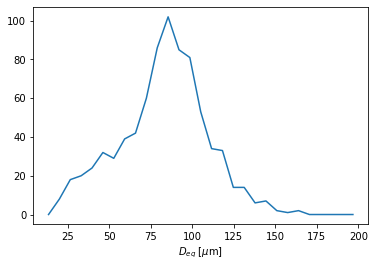

In [11]:
print('Done')


nb_bins = 30
areas_hist_bin = np.linspace(10, 200, nb_bins)
areas_hist, _ = np.histogram(equivalent_cylinder_diameters, bins = areas_hist_bin)
areas_hist_bin_c = 0.5 * (areas_hist_bin[:-1]+areas_hist_bin[1:])

plt.plot(areas_hist_bin_c, areas_hist)
plt.xlabel('$D_{eq}$ [$\mu$m]')


In [12]:
ind_pore = 200

mask_ind_pore = (lab==properties[ind_properties_cleaned[ind_pore]].label) > 0
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPores_particleLabels_checkOnePore').saveTiffStack(mask_ind_pore[::])

print(properties[ind_properties_cleaned[ind_pore]].axis_major_length)
print(properties[ind_properties_cleaned[ind_pore]].axis_minor_length)
print(properties[ind_properties_cleaned[ind_pore]].inertia_tensor)
print(properties[ind_properties_cleaned[ind_pore]].inertia_tensor_eigvals)

bbox = properties[ind_properties_cleaned[ind_pore]].bbox
height = bbox[3]-bbox[0] # Along z, in pixels
equivalent_cylinder_cross_section = properties[ind_properties_cleaned[ind_pore]].area / height
equivalent_cylinder_diameter = np.sqrt(4*equivalent_cylinder_cross_section/np.pi)
print(equivalent_cylinder_diameter)

print('Done')


627.0550365495452
13.178092662313825
[[  553.65507229  2952.24621968  1173.57589474]
 [ 2952.24621968 19221.24683262  -180.47070713]
 [ 1173.57589474  -180.47070713 19596.60281459]]
[19677.069253438585, 19668.584049418398, 25.851416641840615]
12.506713202551014
Done


In [13]:
from skimage.morphology import skeletonize

tic = time.time()
skeleton = skeletonize(mask_pores)
print('Skeletonize took: '+str(time.time()-tic))

# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPores_skeleton').saveTiffStack(skeleton[::10])

NameError: name 'mask_pores' is not defined

In [ ]:
tic = time.time()
skeleton_lab = measure.label(skeleton)
skeleton_properties = measure.regionprops(skeleton_lab)

In [ ]:
for ind_pore in range(len(skeleton_properties)):
    bbox = skeleton_properties[ind_pore].bbox
    skeleton_properties[ind_pore].height = bbox[3]-bbox[0] # Along z, in pixels

skeleton_areas = np.array([prop.area for prop in skeleton_properties])
skeleton_height = np.array([prop.height for prop in skeleton_properties])

skeleton_ind_properties_cleaned = np.where((skeleton_areas>50) * (skeleton_areas < 1000) * (skeleton_height > 100))[0]
print(len(skeleton_ind_properties_cleaned))




In [ ]:
ind_skeleton = 280
prop = skeleton_properties[ind_properties_cleaned[ind_skeleton]]

print(prop.image.shape)
plt.imshow(prop.image[0])

# mask_ind_skeleton = (lab==skeleton_properties[ind_properties_cleaned[ind_skeleton]].label) > 0
mask_ind_skeleton = (skeleton_lab==skeleton_properties[ind_properties_cleaned[ind_skeleton]].label) > 0
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPores_skeleton_checkOne').saveTiffStack(mask_ind_skeleton[::])


In [ ]:
print(np.where(tortuosity>2.5))

ind_skeleton = 2

print(skeleton_properties[skeleton_ind_properties_cleaned[ind_skeleton]].tortuosity)

mask_ind_skeleton = (lab==skeleton_properties[ind_properties_cleaned[ind_skeleton]].label) > 0
File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPores_skeleton_checkOne').saveTiffStack(mask_ind_skeleton[::10])

In [ ]:
ind_skeleton = 280

import networkx as nx

print()
img_skeleton = np.zeros_like(skeleton).astype('bool')
for coor in skeleton_properties[skeleton_ind_properties_cleaned[ind_skeleton]].coords:
    img_skeleton[coor[0], coor[1], coor[2]] = True
print('Done')

import sknw # https://github.com/Image-Py/sknw
graph = sknw.build_sknw(img_skeleton, multi=False, iso=False, ring=False, full=True)
print(graph)

nx.draw(graph)

In [ ]:
def get_path_length(graph, path):
    this_sum=0
    for i in range(len(path)-1):
        this_sum += graph.get_edge_data(path[i], path[i+1])['weight']
    return(this_sum)

def longest_simple_path(graph, source, target):
    longest_path = None
    longest_path_length = 0
    for path in nx.all_simple_paths(graph, source=source, target=target):
        path_length = get_path_length(graph,path)
        if path_length > longest_path_length:
            longest_path_length = path_length
            longest_path = path
    return longest_path, longest_path_length

def find_longest_subgraph_from_ends(graph, bbox):

    ind_end_nodes = [x for x in graph.nodes if graph.degree(x) == 1]
    ind_end_bottom = [x for x in ind_end_nodes if graph.nodes[x]['o'][0] - bbox[0] <=  bbox[3] - graph.nodes[x]['o'][0]]
    ind_end_top = [x for x in ind_end_nodes if not x in ind_end_bottom]

    longest_path_subgraph = None
    longest_path_length = 0
    longest_path = []
    for ind_bot in ind_end_bottom:
        for ind_top in ind_end_top:
            this_longest_path, this_longest_path_length = longest_simple_path(graph, source=ind_bot, target=ind_top)
            this_longest_path_subgraph = graph.subgraph(this_longest_path)

            if this_longest_path_length > longest_path_length:
                longest_path_length = this_longest_path_length
                longest_path = this_longest_path
                longest_path_subgraph = this_longest_path_subgraph

    return(longest_path_subgraph, longest_path, longest_path_length)


for ind_pore in range(len(skeleton_ind_properties_cleaned)):

    bbox = skeleton_properties[skeleton_ind_properties_cleaned[ind_pore]].bbox
    graph = sknw.build_sknw(skeleton_properties[skeleton_ind_properties_cleaned[ind_pore]].image, multi=False, iso=False, ring=False, full=True)
    longest_path_subgraph, longest_path, longest_path_length = find_longest_subgraph_from_ends(graph, bbox)
    if longest_path_length == 0:
        longest_path_length = np.nan
    skeleton_properties[skeleton_ind_properties_cleaned[ind_pore]].length_skeleton = longest_path_length
    skeleton_properties[skeleton_ind_properties_cleaned[ind_pore]].longest_path = longest_path
    # skeleton_properties[skeleton_ind_properties_cleaned[ind_pore]].longest_path_subgraph = longest_path_subgraph
    skeleton_properties[skeleton_ind_properties_cleaned[ind_pore]].tortuosity = longest_path_length / skeleton_properties[skeleton_ind_properties_cleaned[ind_pore]].height

    # print(ind_pore, longest_path_length, skeleton_properties[skeleton_ind_properties_cleaned[ind_pore]].tortuosity)

In [ ]:
tortuosity = np.array([prop.tortuosity for prop in np.array(skeleton_properties)[skeleton_ind_properties_cleaned] if not np.isnan(prop.tortuosity)])

nb_bins = 60
areas_hist_bin = np.linspace(1.0, 2, nb_bins)
areas_hist, _ = np.histogram(tortuosity, bins = areas_hist_bin)
areas_hist_bin_c = 0.5 * (areas_hist_bin[:-1]+areas_hist_bin[1:])

plt.plot(areas_hist_bin_c, areas_hist)
plt.xlabel('Tortuosity')

print(np.nanmean(tortuosity))
print(np.nanmax(tortuosity))



In [169]:
I = properties[ind_properties_cleaned[ind_pore]].inertia_tensor

import scipy.linalg
eigen_values, eigen_vectors = scipy.linalg.eig(I)

print(eigen_values)
print(eigen_vectors)

ind = 1

print(I.dot(eigen_vectors[:,ind]) / eigen_values[ind])
print(eigen_vectors.transpose().dot(I).dot(eigen_vectors))

[   46.04587069+0.j 14693.11571373+0.j 14677.96845309+0.j]
[[-0.98008947  0.17573866  0.09241515]
 [ 0.17831827  0.98376191  0.02037388]
 [ 0.08733403 -0.03644754  0.9955121 ]]
[ 0.17573866+0.j  0.98376191+0.j -0.03644754+0.j]
[[4.60458707e+01 4.53970195e-13 5.59552404e-14]
 [3.33955086e-13 1.46931157e+04 9.92372406e-10]
 [0.00000000e+00 9.92486093e-10 1.46779685e+04]]
